# Samna 0.17 Demo

### 1. Import Samna

In [1]:
import samna
import samna.dynapse1 as dyn1
import sys
sys.path.append("../dynap-se1")
from dynapse1constants import *

import dynapse1utils as ut
import netgen as n
from netgen import Neuron
import time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# open without GUI (for board connected to the remote machine)
model, _ = ut.open_dynapse1(gui=False, select_device=True)

# open with GUI (only with the board connected locally)
model, gui_thread = ut.open_dynapse1(gui=False)
# devices = samna.device.get_unopened_devices()
# model = samna.device.open_device(devices[int(0)])
# api = model.get_dynapse1_api()

[0]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000020
[1]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000030


In [ ]:
# ut.set_parameters_in_txt_file(model, 'tuning_base')
api = model.get_dynapse1_api()
config1 = model.get_configuration()
param_group = config1.chips[0].cores[0].parameter_group
print(param_group.param_map)
# print("Coarse: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_TAU1_N'].coarse_value))
# print("Fine: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_TAU1_N'].fine_value))
# print("Coarse: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_RFR_N'].coarse_value))
# print("Fine: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_RFR_N'].fine_value))
chip_id = 0 
core_id = 0
neuron_id = 1 + 256 * core_id
api.monitor_neuron(chip_id, neuron_id)
# import dynapse1utils as ut
N = 1000 # How many times to repeat a 2s cycle
#cell to observe the tau value
start_time=time.time()
param_group.param_map['IF_TAU1_N'].coarse_value = 5 
param_group.param_map['IF_TAU1_N'].fine_value = 200 
model.update_parameter_group(param_group, chip_id, core_id)
while True:
    param_group.param_map['IF_DC_P'].coarse_value = 4 
    param_group.param_map['IF_DC_P'].fine_value = 200
    # param_group.param_map['IF_RFR_N'].coarse_value = 4 
    # param_group.param_map['IF_RFR_N'].fine_value = 3 

    # print("*******AFTER&&&&&&&&&&&&")
    model.update_parameter_group(param_group, chip_id, core_id)
    # print("Coarse: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_TAU1_N'].coarse_value))
    # print("Fine: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_TAU1_N'].fine_value))
    # print(f"Linear: {config1.chips[0].cores[0].parameter_group.get_linear_parameter('IF_DC_P')}")
    # print("Coarse: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_DC_P'].coarse_value))
    # print("Fine: " + str(config1.chips[0].cores[0].parameter_group.param_map['IF_DC_P'].fine_value))
    time.sleep(0.5)
    param_group.param_map['IF_DC_P'].fine_value = 0
    param_group.param_map['IF_DC_P'].coarse_value = 0
    model.update_parameter_group(param_group, chip_id, core_id)
    # print("Linear: " + str(config1.chips[1].cores[0].parameter_group.get_linear_parameter('IF_DC_P')))
    # print("Coarse: " + str(config1.chips[1].cores[0].parameter_group.param_map['IF_DC_P'].coarse_value))
    # print("Fine: " + str(config1.chips[1].cores[0].parameter_group.param_map['IF_DC_P'].fine_value))
    time.sleep(0.5)
    if time.time()-start_time >= 100:
        break

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wta_testbench_samna import double2pop_code

__all__ = [
    "firing_rates",
    "plot_rate_bar",
    "gaussian_spike_train",
    "plot_raster",
]

# --- helpers ----------------------------------------------------------------

def _as_arr(events):
    return np.asarray([[e.timestamp, e.neuron_id] for e in events], dtype=np.int64)

# --- analysis ----------------------------------------------------------------

def firing_rates(events, neuron_offset: int = 0, num_neurons = None):
    if not events:
        return np.empty(0)
    arr = _as_arr(events)
    if num_neurons is None:
        num_neurons = arr[:, 1].max() - neuron_offset + 1
    dur = arr[:, 0].ptp() or 1
    rates = np.bincount(arr[:, 1] - neuron_offset, minlength=num_neurons) / (dur * 1e-6)
    return rates.astype(float)

# --- plotting ----------------------------------------------------------------

def plot_rate_bar(rates, cluster_size = None, ax = None, conf=(None, None)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    x = np.arange(len(rates))
    ax.bar(x, rates, alpha=.3, width=.8)
    if cluster_size and cluster_size > 1:
        try:
            r = rates.reshape(-1, cluster_size)
            c = np.arange(r.shape[0]) * cluster_size + cluster_size // 2
            ax.errorbar(c, r.mean(1), yerr=r.std(1), fmt="o-", lw=1)
        except:
                print(rates)
                # x = np.arange(len(rates))
                # ax.bar(x, rates, alpha=.3, width=.8)
    ax.set_xlabel("Neuron index")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xlim(0, 128)
    ax.set_title(f"Bump with mean={conf[0]}, std={conf[1]}")
    return fig, ax


def plot_raster(
    events,
    neuron_offset: int = 0,
    neurons_per_core: int = 256,
    cluster_size: int = None,
    time_unit: str = "s",
    s: int = 2,
    figsize=(9, 6),
    ax = None,
):
    """Raster with core colour‑coding and optional cluster dividers."""
    arr = _as_arr(events)
    if not len(arr):
        return (None, None)
    t = arr[:, 0] * (1e-6 if time_unit == "s" else 1)
    n = arr[:, 1] - neuron_offset
    cores = (arr[:, 1] // neurons_per_core).astype(int)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    sc = ax.scatter(t, n, c=cores, cmap="tab10", s=s, marker="|")
    if cluster_size and cluster_size > 1:
        for c in range(0, n.max() + cluster_size, cluster_size):
            ax.axhline(c - .5, lw=.3, color="grey", alpha=.4)
    ax.set_xlabel(f"Time [{time_unit}]")
    ax.set_ylabel("Neuron ID – offset")
    cb = fig.colorbar(sc, ax=ax, ticks=np.unique(cores))
    cb.set_label("Core")
    fig.tight_layout()
    return fig, ax

# --- stimulus synthesis -------------------------------------------------------

def gaussian_spike_train(center, sigma, amplitude, duration_s, input_ids):
    rates = double2pop_code(center, len(input_ids), sigma, amplitude)
    spikes = [[0, int(input_ids[0])]]
    for nid, r in zip(input_ids, rates):
        if r <= 0 or np.isclose(r, 0, 1e-3):
            continue
        print(f"R: {r}")
        isi = int(1e6 / r)
        spikes.extend([[t, int(nid)] for t in range(0, int(duration_s * 1e6), isi)])
    a = np.asarray(spikes, dtype=np.int32)
    a = a[np.argsort(a[:, 0])]
    return a


Exc cluster neuron CAMs:
-> Input:  13
-> EE recurrent:  8
-> EE lateral:  0
-> IE:  4
Total:  25

Inh cluster neuron CAMs:
-> EI:  25
-> II recurrent:  0
Total:  25
Initializing HARD WTA network...
Exc cluster neuron CAMs:
-> Input:  13
-> EE recurrent:  8
-> EE lateral:  0
-> IE:  4
Total:  25

Inh cluster neuron CAMs:
-> EI:  25
-> II recurrent:  0
Total:  25
model ok
netgen ok
SynTypes ok
Neurons ok
Populations ok
Connecting clusters...
Connecting cluster 0 to cluster 0 with p=1.00
Connecting cluster 0 to cluster 1 with p=0.00
Connecting cluster 0 to cluster 2 with p=0.00
Connecting cluster 0 to cluster 3 with p=0.00
Connecting cluster 0 to cluster 15 with p=0.00
Connecting cluster 0 to cluster 14 with p=0.00
Connecting cluster 0 to cluster 13 with p=0.00
Connecting cluster 1 to cluster 1 with p=1.00
Connecting cluster 1 to cluster 2 with p=0.00
Connecting cluster 1 to cluster 3 with p=0.00
Connecting cluster 1 to cluster 4 with p=0.00
Connecting cluster 1 to cluster 0 with p=0.00


Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.
Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.


Init complete
0
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 30}
bump input 1
[ 40  45  42 ... 238  42 243]
[0 0 0 ... 0 0 0]
1
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 50}
bump input 2
[248 247 242 ...  42 243 242]
[0 0 0 ... 0 0 0]
2
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 70}
bump input 3
[ 44  47  43 ... 243 121 238]
[0 0 0 ... 0 0 0]
3
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 90}
bump input 4
[ 42 238  41 ... 236 246 121]
[0 0 0 ... 0 0 0]
4
bump input 5
[ 44 247 251 ... 236 242 241]
[0 0 0 ... 0 0 0]
R: 100.0
R: 3.293714110306081e-07
R: 3.293714110306081e-07
Stimulus loaded
5
bump input 6
[236 241 242 ...  68  70  65]
[0 0 0 ... 0 0 0]
R: 4.393693362340718
R: 0.0883826306935057
Stimulus loaded
6
bump input 7
[ 64 236  65 ... 240 244 253]
[0 0 0 ... 0 0 0]
R: 0.00037266531720785915
R: 45.78333617716168
Stimulus loaded


/var/folders/_q/54sp35x51k732d5mlnsh8fqh0000gn/T/ipykernel_28335/2640535656.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 3))


[]
[array([[ 1,  0, 16],
       [ 1,  0, 17],
       [ 1,  0, 18],
       [ 1,  0, 19],
       [ 1,  0, 20],
       [ 1,  0, 21],
       [ 1,  0, 22],
       [ 1,  0, 23]]), array([[ 1,  0, 24],
       [ 1,  0, 25],
       [ 1,  0, 26],
       [ 1,  0, 27],
       [ 1,  0, 28],
       [ 1,  0, 29],
       [ 1,  0, 30],
       [ 1,  0, 31]]), array([[ 1,  0, 32],
       [ 1,  0, 33],
       [ 1,  0, 34],
       [ 1,  0, 35],
       [ 1,  0, 36],
       [ 1,  0, 37],
       [ 1,  0, 38],
       [ 1,  0, 39]]), array([[ 1,  0, 40],
       [ 1,  0, 41],
       [ 1,  0, 42],
       [ 1,  0, 43],
       [ 1,  0, 44],
       [ 1,  0, 45],
       [ 1,  0, 46],
       [ 1,  0, 47]]), array([[ 1,  0, 48],
       [ 1,  0, 49],
       [ 1,  0, 50],
       [ 1,  0, 51],
       [ 1,  0, 52],
       [ 1,  0, 53],
       [ 1,  0, 54],
       [ 1,  0, 55]]), array([[ 1,  0, 56],
       [ 1,  0, 57],
       [ 1,  0, 58],
       [ 1,  0, 59],
       [ 1,  0, 60],
       [ 1,  0, 61],
       [ 1,  0, 62],

Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.
Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.


Init complete
7
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 30}
bump input 8
[ 60  66  69 ... 248 246 251]
[0 0 0 ... 0 0 0]
8
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 50}
bump input 9
[ 41  48  53 ... 249 251 243]
[0 0 0 ... 0 0 0]
9
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 70}
bump input 10
[252 248 250 ... 246 249 247]
[0 0 0 ... 0 0 0]
10
{'value1': 0.2, 'value2': 0.8, 'sigma': 0.01, 'amplitude1': 100, 'amplitude2': 90}
bump input 11
[121 123 127 ... 245 249 247]
[0 0 0 ... 0 0 0]
11
bump input 12
[249 253 245 ... 239 241 255]
[0 0 0 ... 0 0 0]
R: 100.0
R: 3.293714110306081e-07
R: 3.293714110306081e-07
Stimulus loaded
12
bump input 13
[ 30  24  27 ... 252  79  80]
[0 0 0 ... 0 0 0]
R: 4.393693362340718
R: 0.0883826306935057
Stimulus loaded
13
bump input 14
[ 79  78  65 ... 121 122 124]
[0 0 0 ... 0 0 0]
R: 0.00037266531720785915
R: 45.78333617716168
Stimulus loaded
final b

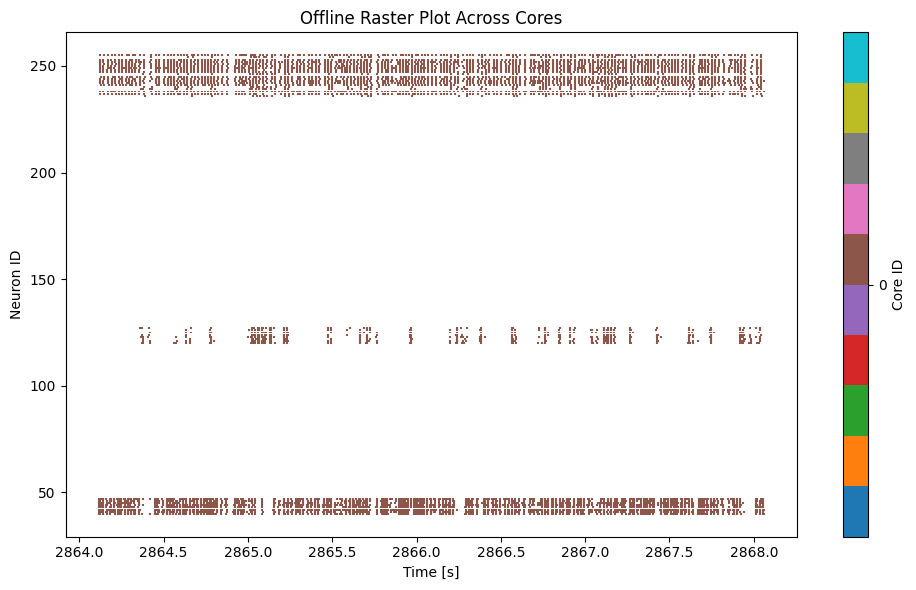

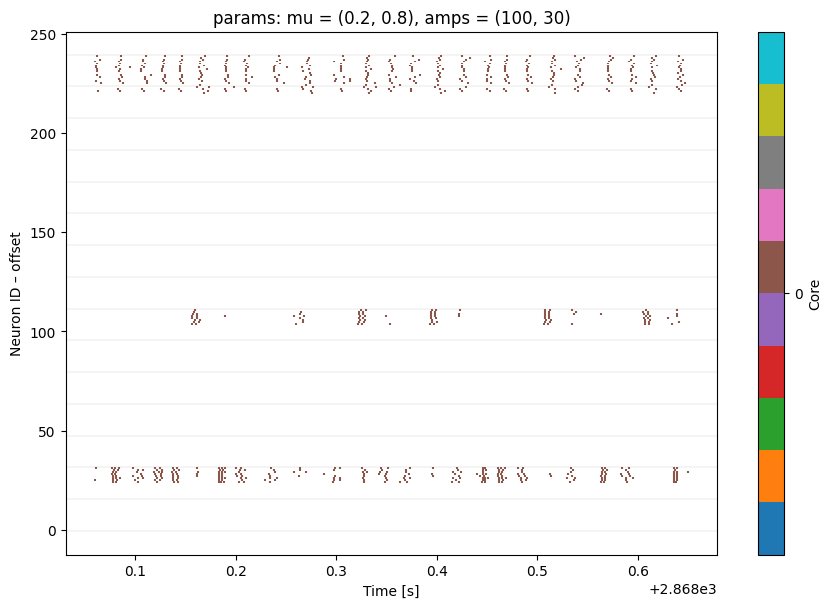

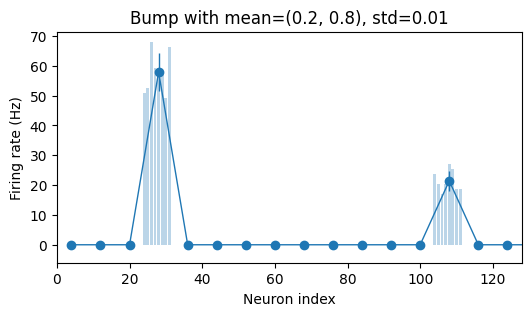

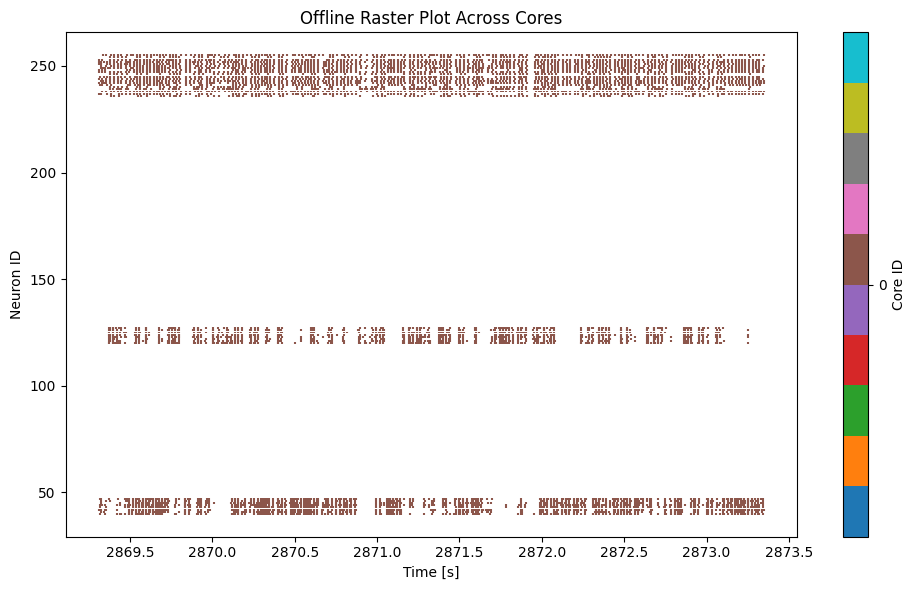

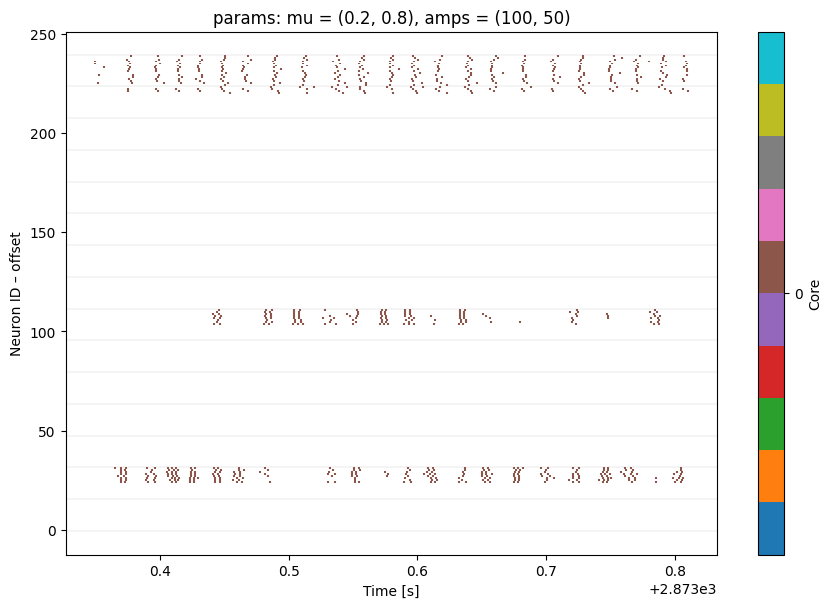

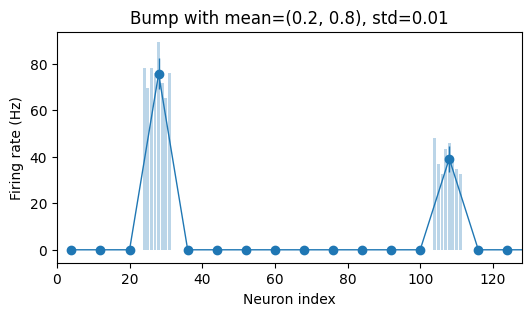

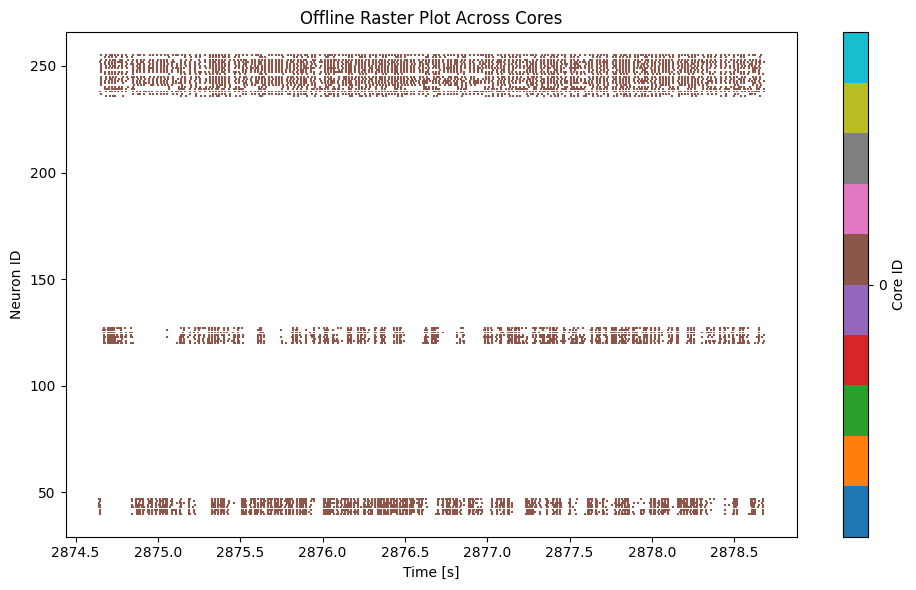

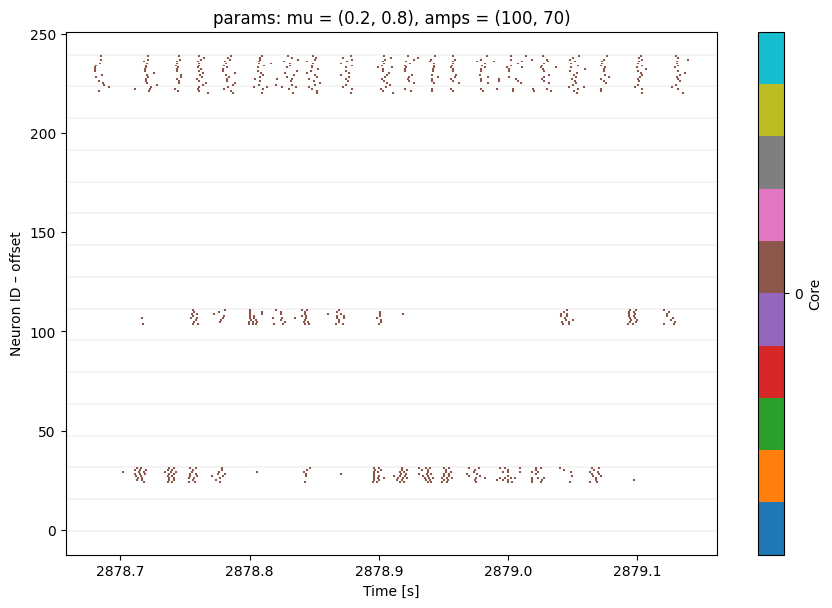

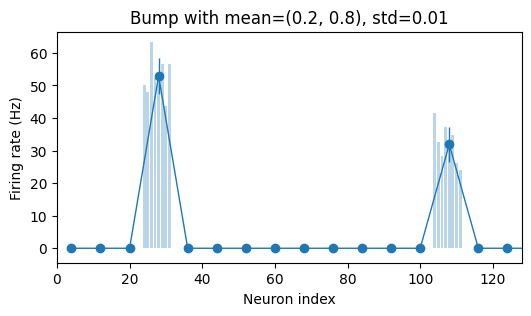

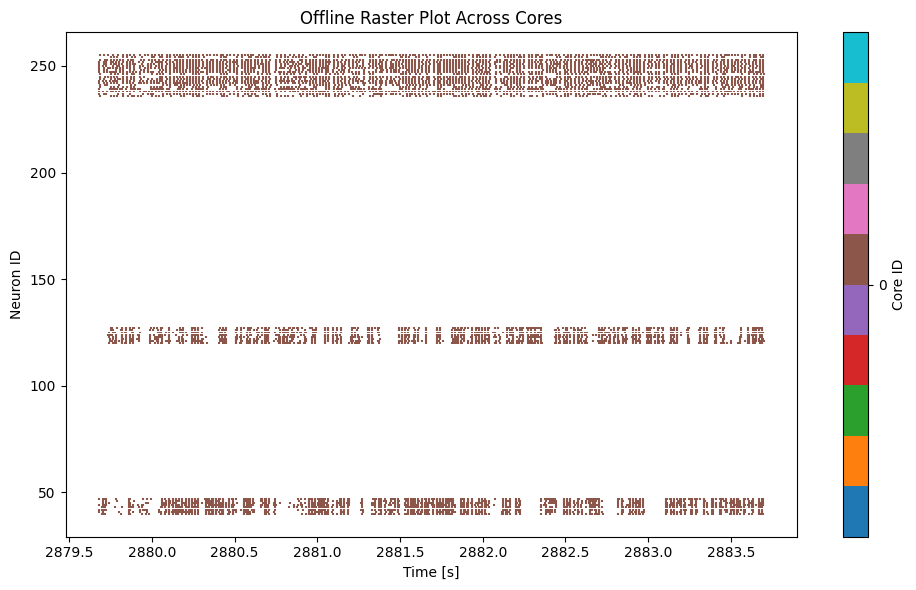

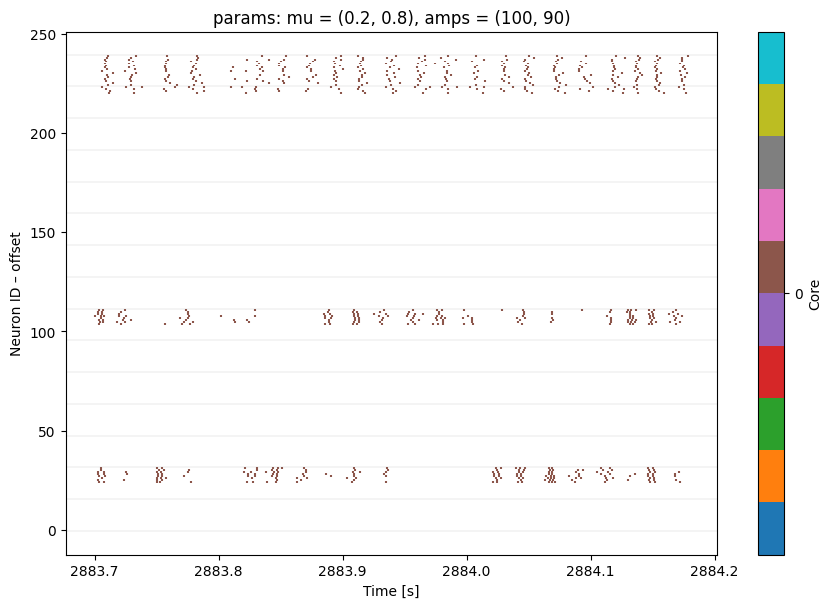

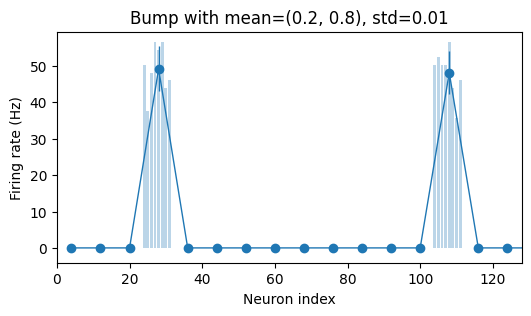

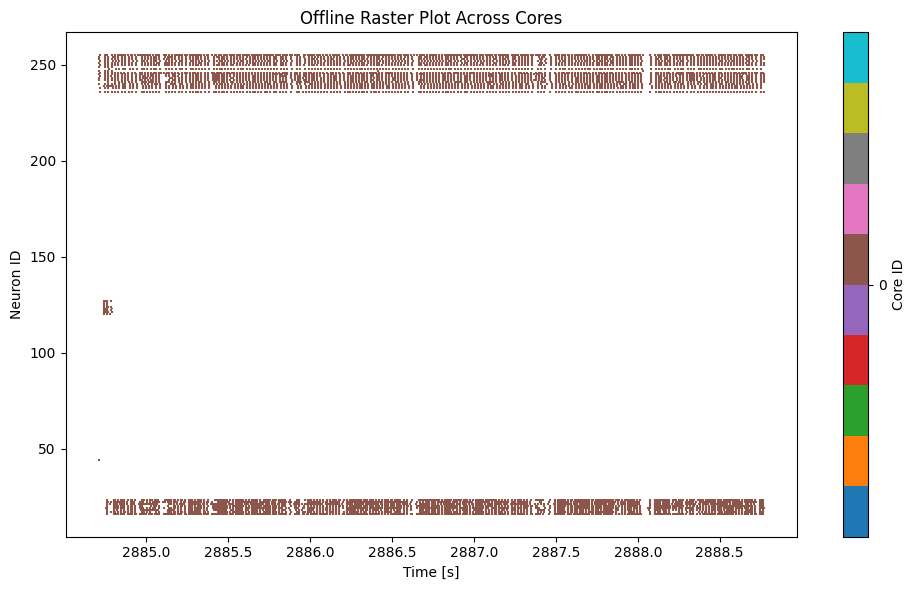

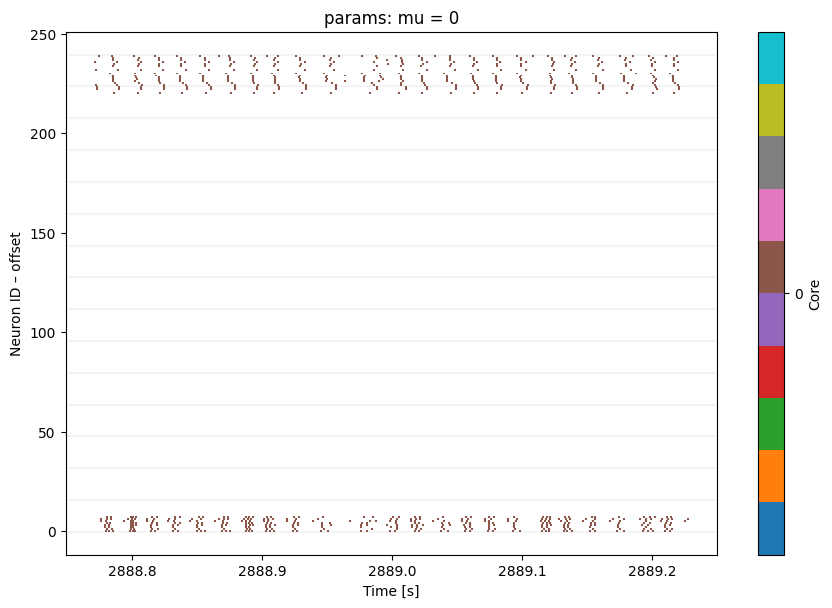

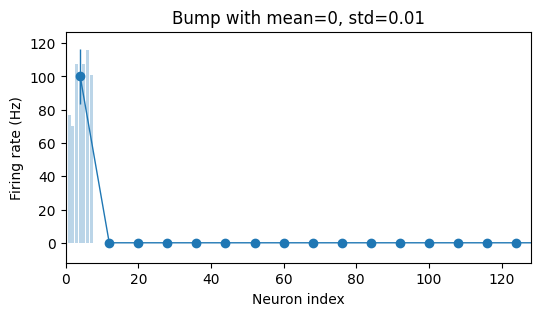

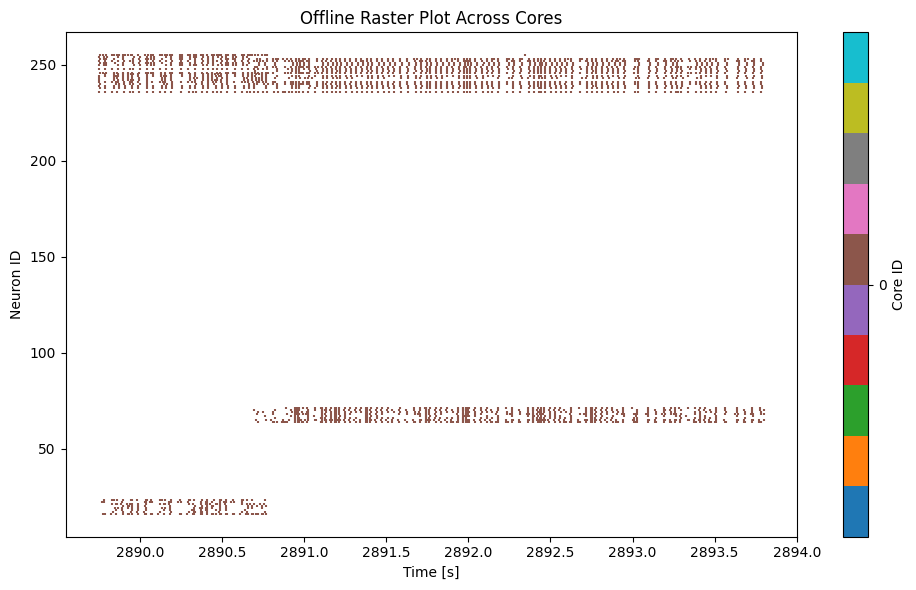

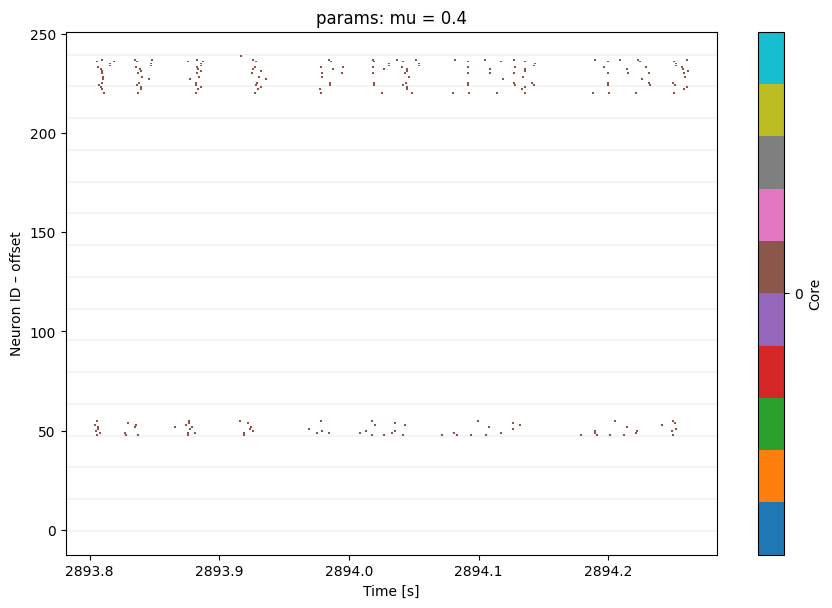

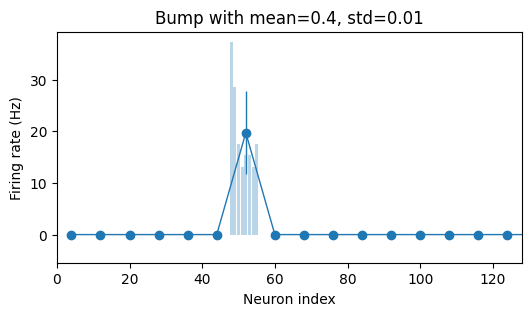

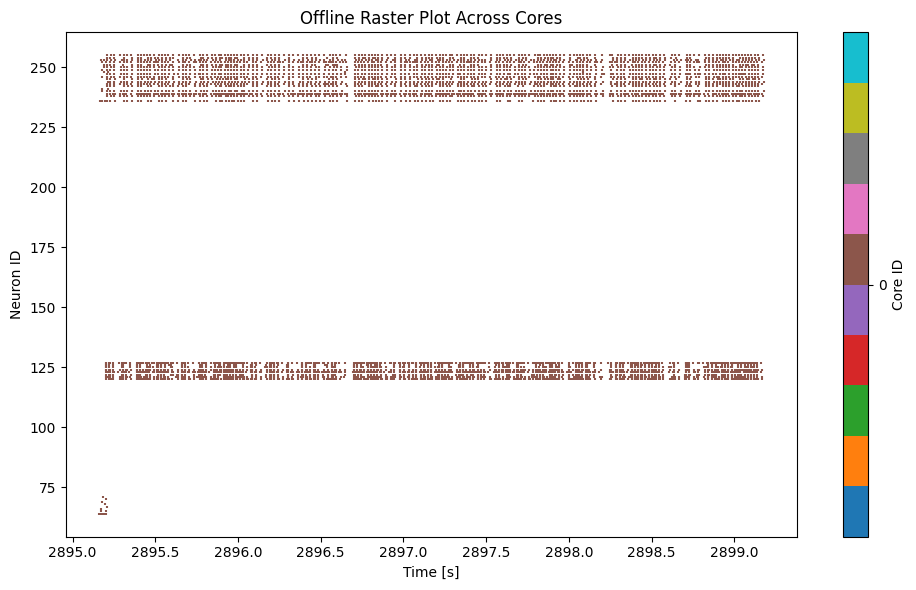

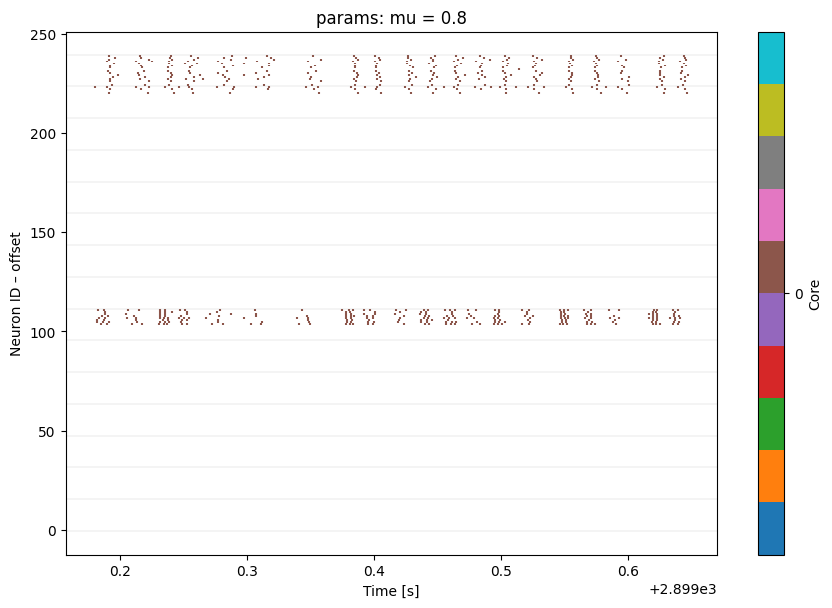

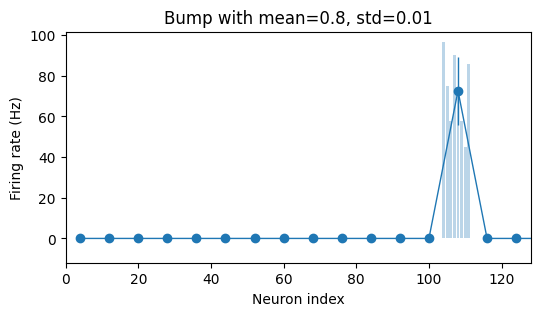

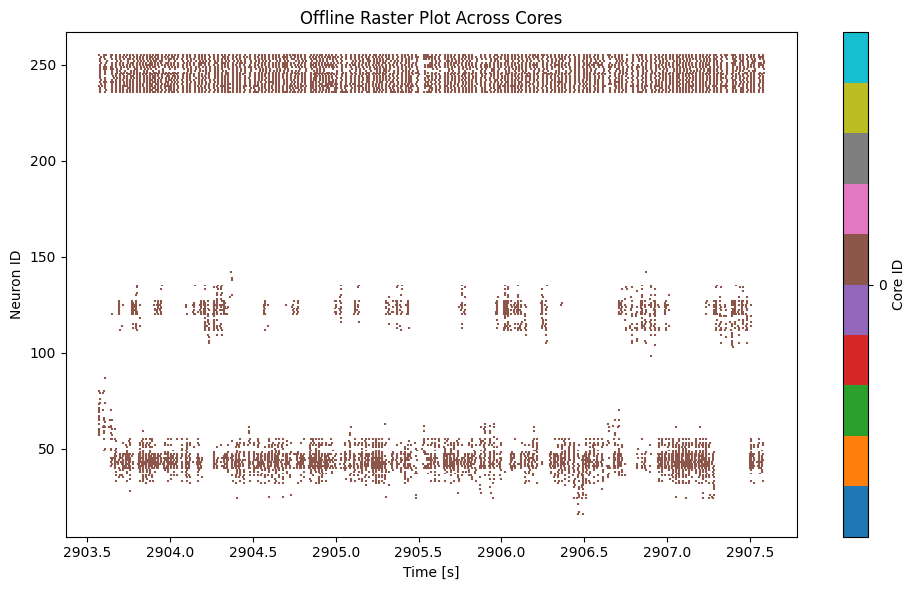

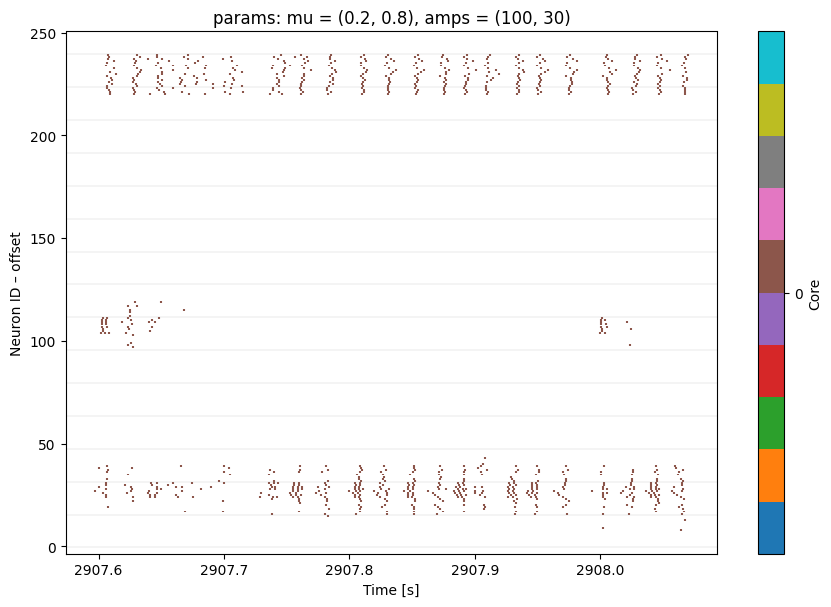

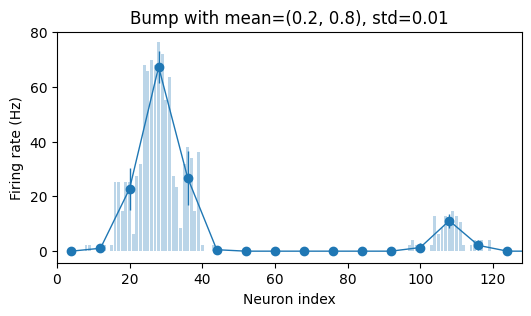

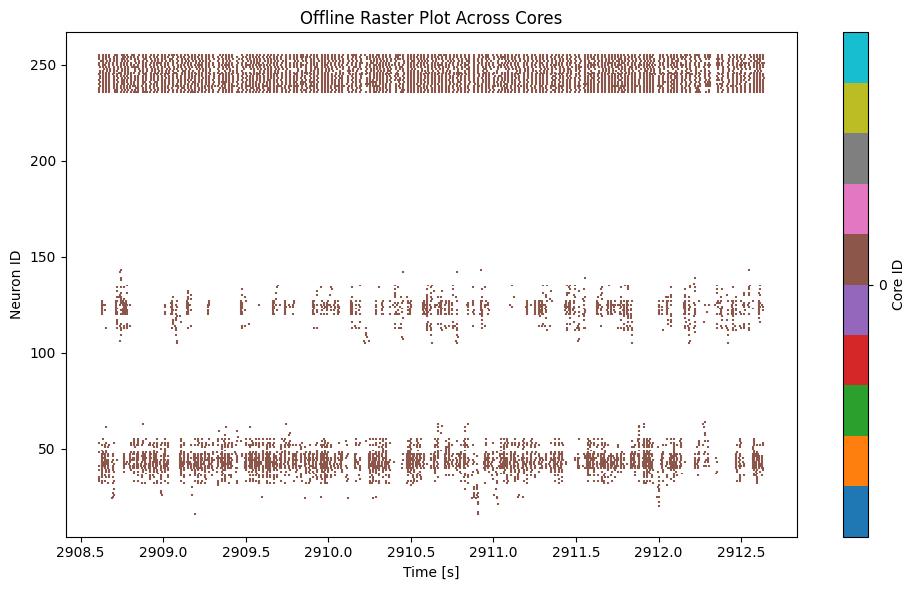

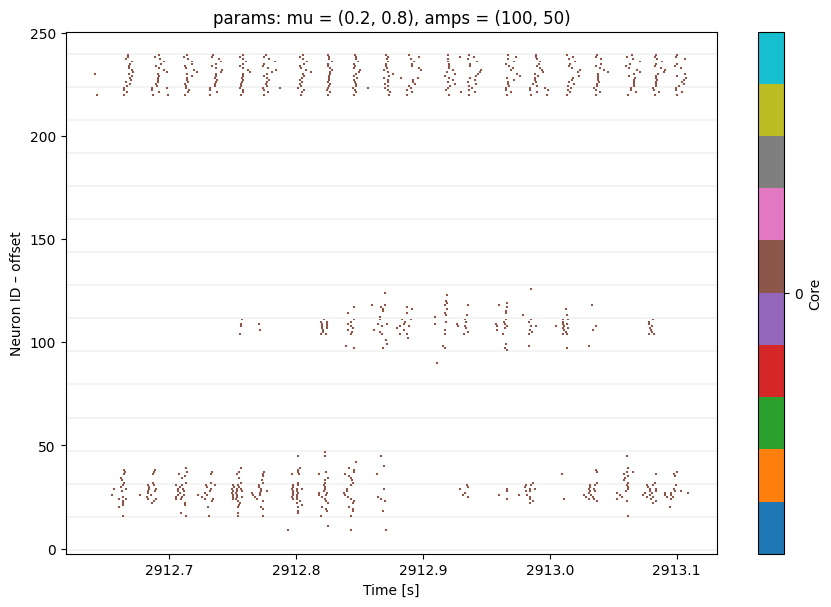

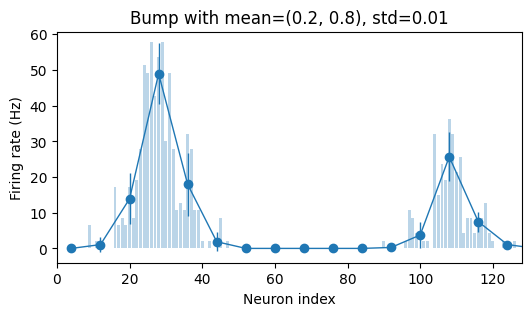

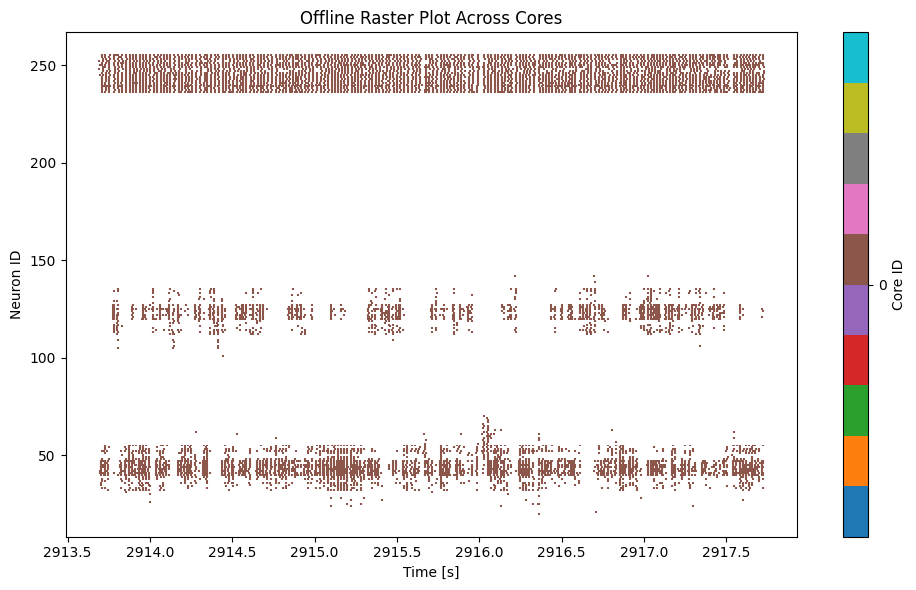

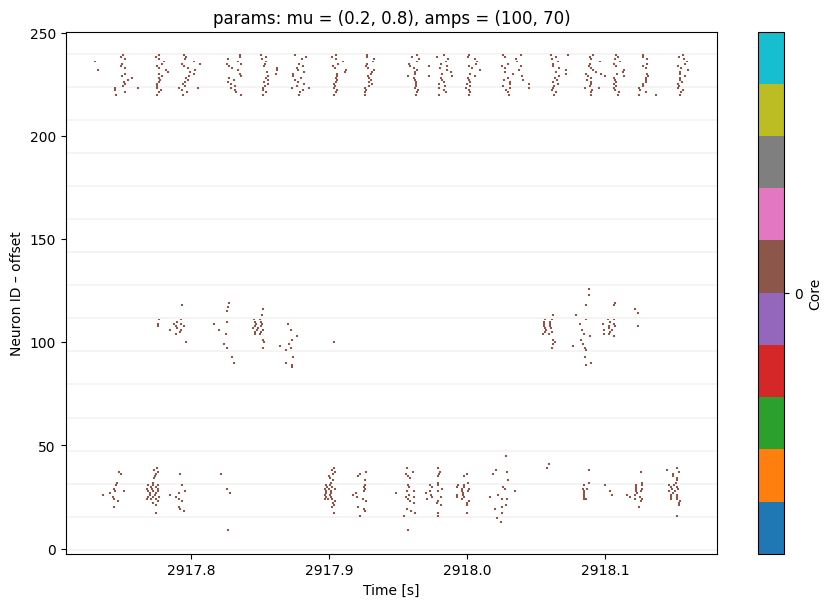

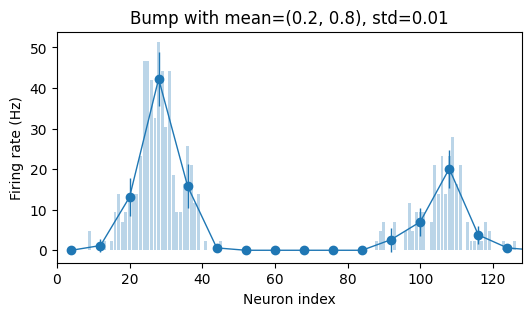

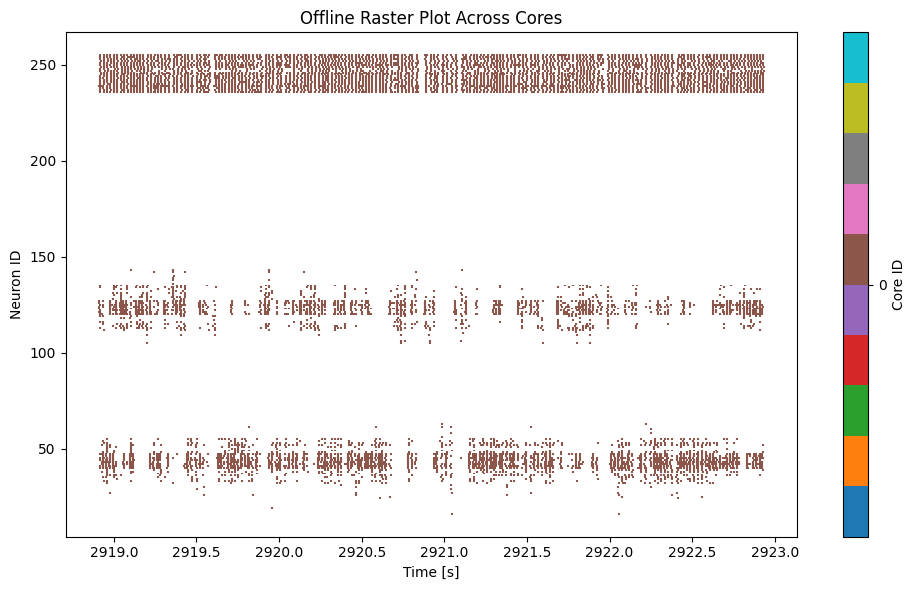

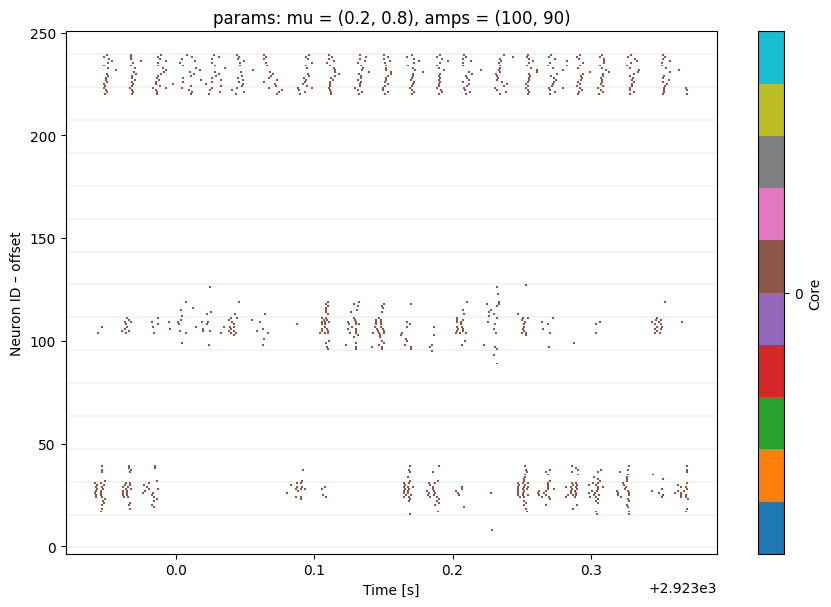

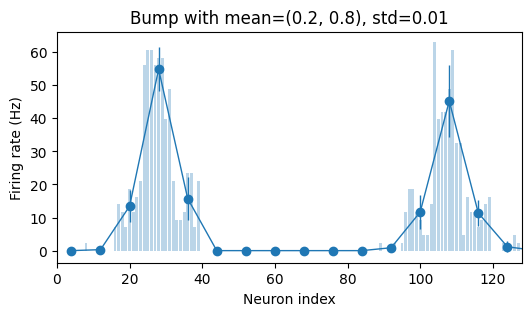

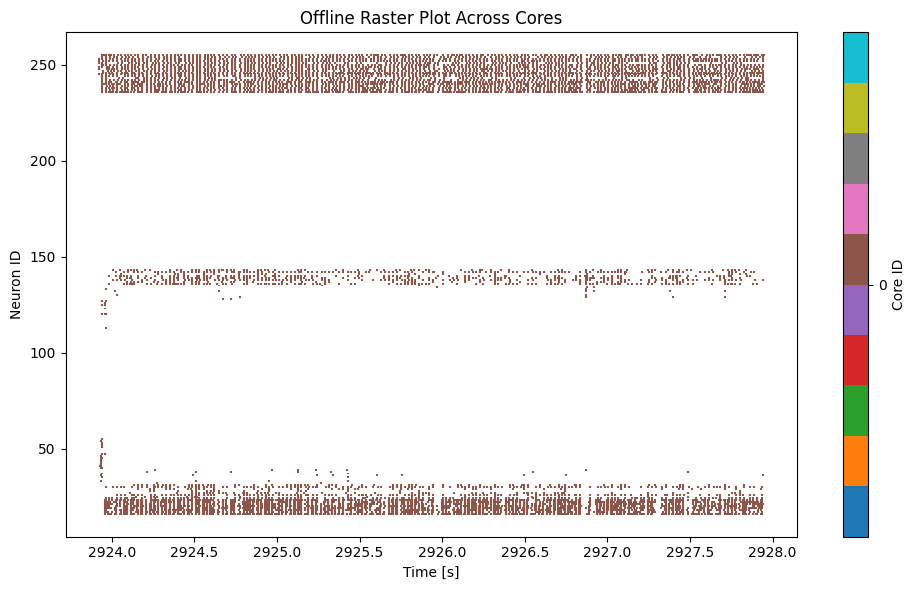

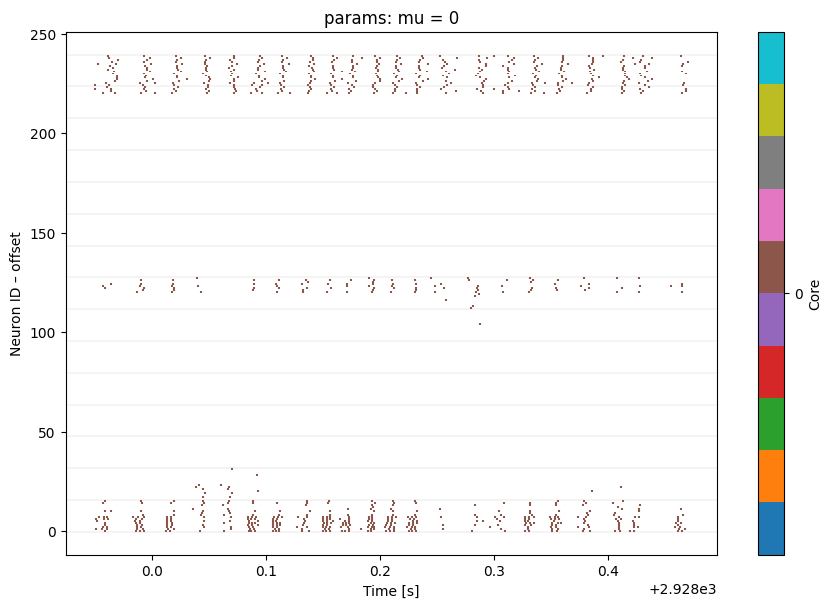

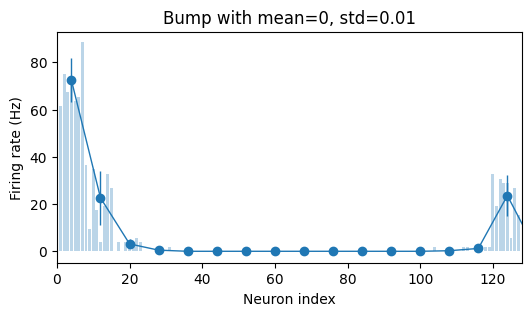

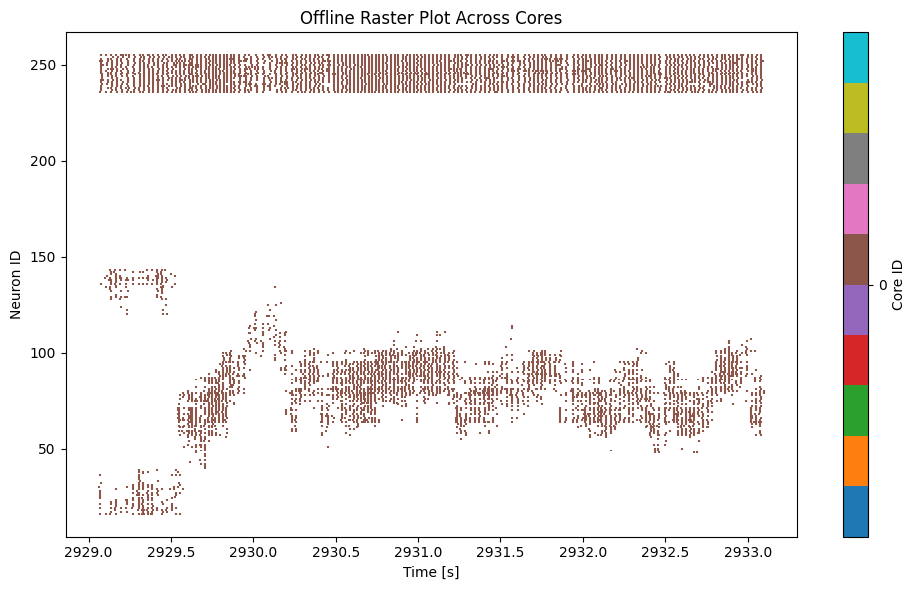

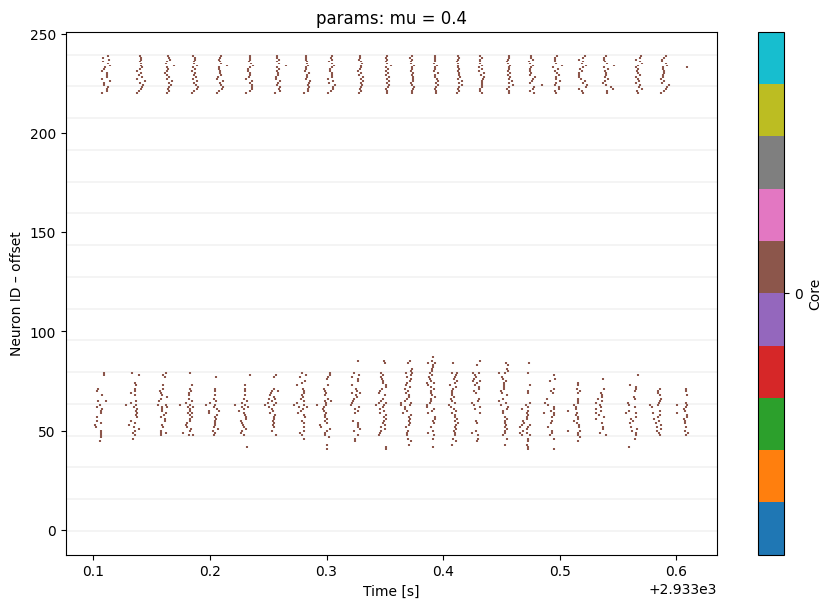

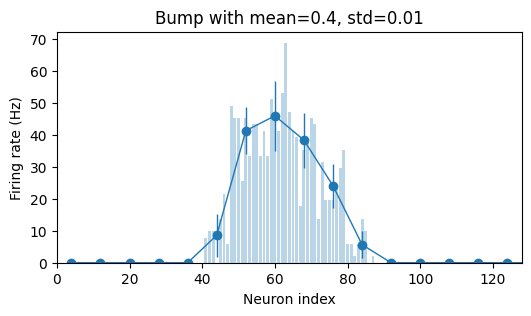

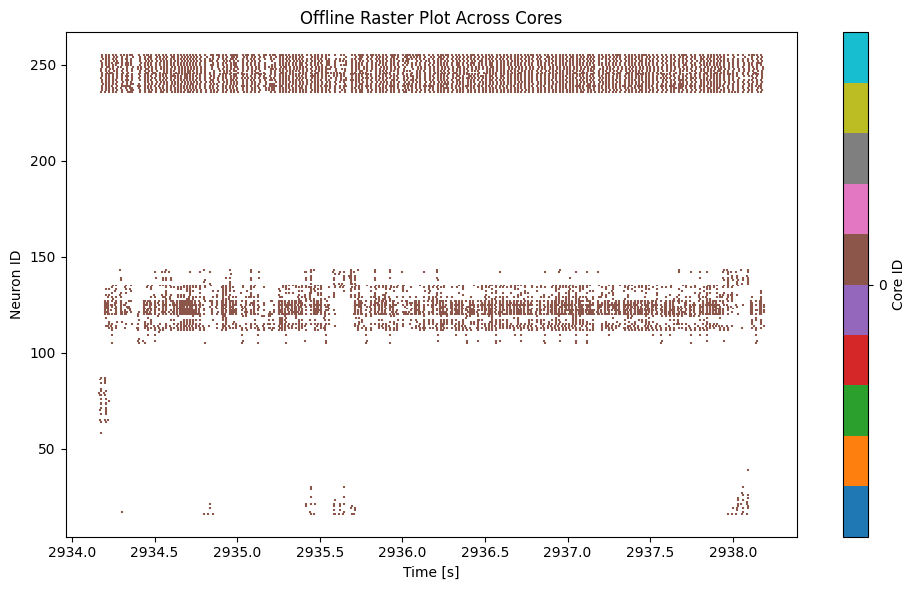

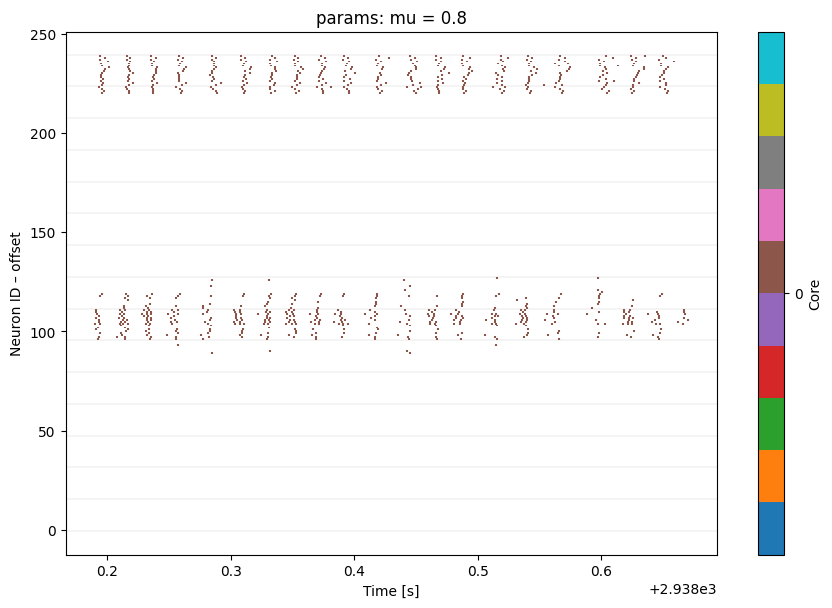

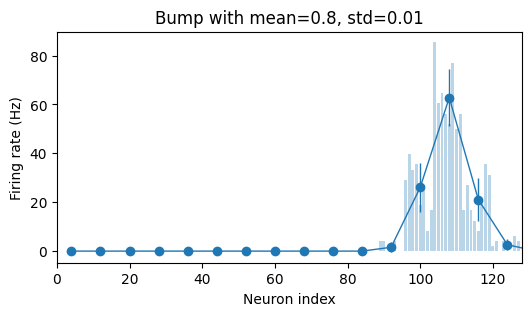

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 14 17:57:12 2019

@author: dzenn
"""
#%% Import all needed modules

from wta_testbench_samna import DynapseTestGroup, double2pop_code, pop_code2double, check_cams_per_neuron_clustered_wta
from wta_testbench_samna import connect_populations

import matplotlib.pyplot as plt
import numpy as np
from random import sample
from time import sleep
import matplotlib.image as mpimg
import sys
# from wta_recording_tools import *

from math import pi
# !pip3 install scipy
from scipy import stats
from scipy.signal import find_peaks

import samna
import dynapse1utils as ut
ut.set_parameters_in_txt_file(model, 'selective_amp_global_inh_WTA_better')

# @njit
def get_neuron_rates(spiketimes, neuron_ids, num_neurons, time_window=1):
    rates = np.zeros(num_neurons)
    max_timestamp = spiketimes[-1]
    for spike_id in np.arange(len(spiketimes)):
        if max_timestamp-spiketimes[spike_id] < time_window:
            rates[neuron_ids[spike_id]] += 1
    
    return rates

def get_activity(spiketimes, neuron_ids, mask_ids, time_window=0.1):
    
    x = []
    y = []
    
    t_start = spiketimes[0]
    t_end = spiketimes[-1]
    
    spike_id=0
    spike_id_last=len(spiketimes)
    
    for t_current in np.arange(t_start+time_window, t_end, time_window):
        activity_current = 0
        while(spike_id<spike_id_last and spiketimes[spike_id] < t_current):
            if (neuron_ids[spike_id] >= mask_ids[0] and neuron_ids[spike_id] < mask_ids[1]):
                activity_current += 1
            spike_id += 1
        x.append(t_current)
        y.append(activity_current/((mask_ids[1] - mask_ids[0])*time_window))
        
    return np.array(x), np.array(y)


plot_cnt = 0

def bump_and_plot(TG, sleep_t, double=False, *args, **kwargs):
    global plot_cnt
    print(plot_cnt)
    if double:
        print(kwargs)
        TG.set_double_bump_input(*args, **kwargs)
        # TG.set_double_bump_input(value1=0.3, value2=0.7, sigma=0.01)
    else:
        TG.set_bump_input(*args, **kwargs)
    sleep(sleep_t)
    plot_cnt += 1
    plot_i(TG, plot_cnt)

# run_threaded_gui(model)

#%% Select a neuron for monitoring

api = model.get_dynapse1_api()

chip_id = 0 
neuron_id = 1 

chip_id = 0 
core_id = 0
neuron_id = 5 + 256 * core_id
api.monitor_neuron(chip_id, neuron_id)


#%% Global INH 16 clusters, hard WTA

start_neuron=16
exc_size=128

chip_id=1
core_id=0
mode='clustered_WTA'
# mode='ff'
exc_cluster_size=8
inh_cluster_size=4

inh_size=20
connectivity={'wta_structure': 'global_inh',
                'ee_recurrent': 1.0,
                'ee_lateral':0.0,
                'ee_lateral_2nd':0.0,
                'ee_lateral_3rd':0.0,
                'ei': 0.2,
                'ie': 0.2,
                'ii': 0.0,
                'ee_global':0.0,
                'ei_global':0.0,
                'exc_global_size': 0}


input_multiplier=13
clustered_input = True
allow_self_exc = False
debug = True

check_cams_per_neuron_clustered_wta(exc_cluster_size, inh_size, exc_size/exc_cluster_size, connectivity, input_multiplier, print_detailed=True)

#%%

print("Initializing HARD WTA network...")

TG = DynapseTestGroup(model, start_neuron,exc_size,inh_size,chip_id,core_id,mode,core_id+1, None, exc_cluster_size,inh_cluster_size,connectivity,input_multiplier,clustered_input,allow_self_exc,debug=debug)
ut.set_parameters_in_txt_file(model, 'selective_amp_global_inh_WTA_better')

def plot_raster_offline(events, cores=4, neurons_per_core=256, time_unit='s', figsize=(10,6), s=2):
    """
    events: list of objects with .timestamp (µs) and .neuron_id (global 0…cores*neurons_per_core-1)
    """
    arr = np.array([[e.timestamp, e.neuron_id] for e in events])
    times = arr[:,0] * (1e-6 if time_unit=='s' else 1)
    nids = arr[:,1].astype(int)
    print(nids)
    core_ids = nids // neurons_per_core
    print(core_ids)

    fig, ax = plt.subplots(figsize=figsize)
    sc = ax.scatter(times, nids, c=core_ids, cmap='tab10', s=s, marker='|')
    ax.set_xlabel(f"Time [{time_unit}]")
    ax.set_ylabel("Neuron ID")
    ax.set_title("Offline Raster Plot Across Cores")
    cbar = fig.colorbar(sc, ticks=range(cores), ax=ax)
    cbar.set_label('Core ID')
    plt.tight_layout()
    return fig, ax

def plot_i(tg, i):
    print(f"bump input {i}")
    evts = tg.sink_node.get_events()
    _, ax = plot_raster_offline(evts)
    ax.figure.savefig(f"latest_{i}.png", dpi=300)


### ______ DOUBLE BUMP TEST __________________
# mu = [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6)]
# amps = [(100, 30), (100, 30), (100, 30), (100, 30), (100, 30)] # constant amplitude over trials 
mu = [(0.2, 0.8), (0.2, 0.8), (0.2, 0.8), (0.2, 0.8)]
amps = [(100, 30), (100, 50), (100, 70), (100, 90)]
sig = 0.01
for i,m in enumerate(mu):
    e = TG.sink_node.get_events()
    bump_and_plot(TG, 4.0, double=True, value1=m[0], value2=m[1], sigma=sig, amplitude1=amps[i][0], amplitude2=amps[i][1])
    # spk = gaussian_spike_train(m, sig, 100, 1.0, TG.input_ids)
    # TG.set_preloaded_stimulus(spk, True)
    evts   = TG.sink_node.get_events()
    rates  = firing_rates(evts, neuron_offset=TG.start_neuron)
    _, ax = plot_raster(
        evts,
        neuron_offset=TG.start_neuron,
        neurons_per_core=256,
        cluster_size=16,   # draws thin grey lines between clusters
    )
    ax.set_title(f"params: mu = {m}, amps = {amps[i]}")
    ax.figure.savefig(f"raster_double_{i}.png", dpi=300)
    fig, ax = (
        plot_rate_bar(rates, cluster_size=TG.exc_cluster_size, conf=(mu[i],sig)) # shows bar + cluster means
    )
    ax.figure.savefig(f"rates_double_{i}")
# wta_live_plotter.run_plotting_thread(TG.running_raster_sink_node, 20, [TG.exc_population_ids[:,2], TG.inh_population_ids[:,2]], TG=TG)
# gaussian stimulus (1 s centred at first param)
mu = [0, 0.4, 0.8]
sig = 0.01
for i,m in enumerate(mu):
    e = TG.sink_node.get_events()
    bump_and_plot(TG, 4.0, False, m, sig)
    spk = gaussian_spike_train(m, sig, 100, 1.0, TG.input_ids)
    TG.set_preloaded_stimulus(spk, True)
    evts   = TG.sink_node.get_events()
    rates  = firing_rates(evts, neuron_offset=TG.start_neuron)
    _, ax = plot_raster(
        evts,
        neuron_offset=TG.start_neuron,
        neurons_per_core=256,
        cluster_size=16,   # draws thin grey lines between clusters
    )
    ax.figure.savefig(f"raster_{i}.png", dpi=300)
    ax.set_title(f"params: mu = {m}")
    fig, ax = (
        plot_rate_bar(rates, cluster_size=TG.exc_cluster_size, conf=(mu[i],sig)) # shows bar + cluster means
    )
    ax.figure.savefig(f"rates_{i}")
print(f"{TG.inh_cluster_neuron_ids}")
print(f"{TG.exc_cluster_neuron_ids}")

#%% Global INH 16 clusters, soft WTA

start_neuron=16
exc_size=128

chip_id=1
core_id=0
mode='clustered_WTA'
# mode='ff'
exc_cluster_size=8
inh_cluster_size=4

inh_size=20
connectivity={'wta_structure': 'global_inh',
                'ee_recurrent': 0.8,
                'ee_lateral': 0.5,
                'ee_lateral_2nd':0.0,
                'ee_lateral_3rd':0.0,
                'ei': 0.2,
                'ie': 0.2,
                'ii': 0.0,
                'ee_global':0.0,
                'ei_global':0.0,
                'exc_global_size': 0}


input_multiplier=13
clustered_input = True
allow_self_exc = False 
debug = True

check_cams_per_neuron_clustered_wta(exc_cluster_size, inh_size, exc_size/exc_cluster_size, connectivity, input_multiplier, print_detailed=True)

# load_ctxctl_biases("biases/global_inh_WTA", model)


# %% Run the config

print("Initializing SOFT WTA network...")

TG = DynapseTestGroup(model, start_neuron,exc_size,inh_size,chip_id,core_id,mode,core_id+1, None, exc_cluster_size,inh_cluster_size,connectivity,input_multiplier,clustered_input,allow_self_exc,debug=debug)
ut.set_parameters_in_txt_file(model, 'project/selective_amp_global_inh_WTA_better')


### ______ DOUBLE BUMP TEST __________________
# mu = [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6)]
# amps = [(100, 30), (100, 30), (100, 30), (100, 30), (100, 30)] 
mu = [(0.2, 0.8), (0.2, 0.8), (0.2, 0.8), (0.2, 0.8)]
amps = [(100, 30), (100, 50), (100, 70), (100, 90)]
sig = 0.01
for i,m in enumerate(mu):
    e = TG.sink_node.get_events()
    bump_and_plot(TG, 4.0, double=True, value1=m[0], value2=m[1], sigma=sig, amplitude1=amps[i][0], amplitude2=amps[i][1])
    # spk = gaussian_spike_train(m, sig, 100, 1.0, TG.input_ids)
    # TG.set_preloaded_stimulus(spk, True)
    evts   = TG.sink_node.get_events()
    rates  = firing_rates(evts, neuron_offset=TG.start_neuron)
    _, ax = plot_raster(
        evts,
        neuron_offset=TG.start_neuron,
        neurons_per_core=256,
        cluster_size=16,   # draws thin grey lines between clusters
    )
    ax.set_title(f"params: mu = {m}, amps = {amps[i]}")
    ax.figure.savefig(f"raster_double_soft_{i}.png", dpi=300)
    fig, ax = (
        plot_rate_bar(rates, cluster_size=TG.exc_cluster_size, conf=(mu[i],sig)) # shows bar + cluster means
    )
    ax.figure.savefig(f"rates_double_soft_{i}")

### SINGLE BUMP TEST
mu = [0, 0.4, 0.8]
sig = 0.01
for i,m in enumerate(mu):
    e = TG.sink_node.get_events()
    bump_and_plot(TG, 4.0, False, m, sig)
    spk = gaussian_spike_train(m, sig, 100, 1.0, TG.input_ids)
    TG.set_preloaded_stimulus(spk, True)
    evts   = TG.sink_node.get_events()
    rates  = firing_rates(evts, neuron_offset=TG.start_neuron)
    _, ax = plot_raster(
        evts,
        neuron_offset=TG.start_neuron,
        neurons_per_core=256,
        cluster_size=16,   # draws thin grey lines between clusters
    )
    ax.set_title(f"params: mu = {m}")
    ax.figure.savefig(f"raster_soft_{i}.png", dpi=300)
    fig, ax = (
        plot_rate_bar(rates, cluster_size=TG.exc_cluster_size, conf=(mu[i],sig)) # shows bar + cluster means
    )
    ax.figure.savefig(f"rates_soft_{i}")

# ### BUMP 1
# TG.set_bump_input(0.9, sigma=0.05)
# sleep(3)

# ### BUMP 2
# TG.set_bump_input(0.6, sigma=0.05)
# sleep(3)

# ## BUMP 3
# TG.set_bump_input(0.3, 0.01)
# sleep(3)

# ## BUMP 4
# sleep(2)
# TG.set_bump_input(0.3, 0.15, amplitude=0)
# sleep(2)

# ## BUMP 5
# TG.set_bump_input(0.8, 0.1, amplitude=100)
# sleep(2)

# ## BUMP 6
# TG.set_bump_input(0.8, 0.15, amplitude=1)
# sleep(2)

# TG.set_bump_input(0.5, 0.1, amplitude=100)
# sleep(6)

#%% Load biases
print("final bump")
print("(soft WTA)complete")


In [10]:
# ut.close_dynapse1(model)

#### 1.1 Open the bias GUI (only if the Dynap-SE1 board is connected locally)

In [ ]:
# from live_gui.sliderGui import run_threaded_gui

# run_threaded_gui(model)

#gui = sliderGui(model)

#### 1.2 Monitor single neurons with oscilloscope (if an Agilent oscilloscope is connected)

First, we make the board output the membrane voltage of a specific neuron to the output socket.

**Note:** we specify `chip_id` __[0..3]__ and `neuron_id` __[0..1023]__, but the oscilloscope probe should be connected to the socket of the corresponding **core**.

In [10]:
# api  =  model.get_dynapse1_api()

chip_id = 1
neuron_id = 10

api.monitor_neuron(chip_id, neuron_id)

#### 1.3 Oscilloscope access

Using the `pygetscope` library it is possible to get the traces directly and process the waveforms in python.

Please refer to [PyGetScope ReadMe](https://code.ini.uzh.ch/ncs/libs/pygetscope) for the full class reference.

In [12]:
# !pip3 install pyvisa-py
# from pygetscope.py_scope import PyScope

# my_scope = PyScope()

In [ ]:
# Get the waveform from channel 1 and plot it
wf = my_scope.get_waveform(channel=1, instant_plot=True)

In [ ]:
wf2= my_scope.get_waveform(channel=1, instant_plot=True)

#### 1.4 Oscilloscope on Zemo access

Using the `PySpcmScope` library, it is possible to get the traces directly from Zemo. 

Please refer to [PySpcmScope demo notebook or ReadMe](https://code.ini.uzh.ch/sapta/pyspcmscope) for the full class reference and examples.

In [ ]:
from pyspcmscope.py_spcm_scope import PySpecScope
my_scope = PySpecScope()
my_scope.single_shot() 

In [ ]:
num_samples=200 #in Kilo Samples
sampling_rate=100 #in KHZ

abc=my_scope.get_waveform_single(CH_ID=7)
time=np.linspace(0.0, num_samples/(sampling_rate), num=np.shape(abc)[0], endpoint=True)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
plt.plot(time,abc)

## 2. Board Configurations

`configuration` is an object returned by the `model` that keeps track of the **parameters** (or **biases**) set on the board, and the list of **connections**. Between the neurons.

### Let's see what's inside the configuration

Configuration represents state of the device

In [15]:
config1 = model.get_configuration()

In [16]:
dir(config1.chips[0].cores[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'chip_id',
 'core_id',
 'from_json',
 'neurons',
 'parameter_group',
 'to_json']

### Check biases in the parameter group

`parameter_group` object of each core contains the values of each parameter with then `param_map` dictionary.

Each parameter (bias) can be set either as a tuple of two values (coarse [0..7], fine [0..255]) or as a single (linear [0..2.4+e08]) value covering the same range.

In [18]:
print("Linear: " + str(config1.chips[1].cores[0].parameter_group.get_linear_parameter('IF_TAU1_N')))
print("Coarse: " + str(config1.chips[1].cores[0].parameter_group.param_map['IF_TAU1_N'].coarse_value))
print("Fine: " + str(config1.chips[1].cores[0].parameter_group.param_map['IF_TAU1_N'].fine_value))

Linear: 14117648.0
Coarse: 5
Fine: 90


In [16]:
param_group = config1.chips[0].cores[0].parameter_group

In [17]:
param_group.param_map.keys()

dict_keys(['IF_AHTAU_N', 'IF_AHTHR_N', 'IF_AHW_P', 'IF_BUF_P', 'IF_CASC_N', 'IF_DC_P', 'IF_NMDA_N', 'IF_RFR_N', 'IF_TAU1_N', 'IF_TAU2_N', 'IF_THR_N', 'NPDPIE_TAU_F_P', 'NPDPIE_TAU_S_P', 'NPDPIE_THR_F_P', 'NPDPIE_THR_S_P', 'NPDPII_TAU_F_P', 'NPDPII_TAU_S_P', 'NPDPII_THR_F_P', 'NPDPII_THR_S_P', 'PS_WEIGHT_EXC_F_N', 'PS_WEIGHT_EXC_S_N', 'PS_WEIGHT_INH_F_N', 'PS_WEIGHT_INH_S_N', 'PULSE_PWLK_P', 'R2R_P'])

### The full list of biases available:

- IF_AHTAU_N - Neuron’s firing threshold adaptation time constant
- IF_AHTHR_N - Neuron’s firing threshold max value
- IF_AHW_P - Neuron’s firing threshold adaptation weight (how much the threshold rises with each spike) 
- IF_BUF_P - N\A
- IF_CASC_N - Enables firing threshold adaptation
- IF_DC_P - DC current injected into a neuron
- IF_NMDA_N - Enable NMDA gating
- IF_RFR_N - Neuron refractory period
- IF_TAU1_N - Main neuron time constant (unless switched to TAU2)
- IF_TAU2_N - Secondary time constant (for every neuron either TAU1 or TAU2 can be selected)
- IF_THR_N - Neuron V_mem gain (not the firing threshold!)
- NPDPIE_TAU_F_P - Fast excitatory (AMPA) synapses time constant
- NPDPIE_TAU_S_P - Slow excitatory (NMDA) synapses time constant
- NPDPIE_THR_F_P - Fast excitatory (AMPA) synapses threshold (i.e. max I_syn value)
- NPDPIE_THR_S_P - Slow excitatory (NMDA) synapses threshold (i.e. max I_syn value)
- NPDPII_TAU_F_P - Fast inhibitory (GABA_A) synapses time constant
- NPDPII_TAU_S_P - Slow inhibitory (GABA_B) synapses time constant
- NPDPII_THR_F_P - Fast inhibitory (GABA_A) synapses threshold ((i.e. max I_syn value)
- NPDPII_THR_S_P - Slow inhibitory (GABA_B) synapses threshold (i.e. max I_syn value)
- PS_WEIGHT_EXC_F_N - Fast excitatory (AMPA) synapse weights
- PS_WEIGHT_EXC_S_N - Slow excitatory (NMDA) synapse weights
- PS_WEIGHT_INH_F_N - Fast inhibitory (GABA_A) synapse weights
- PS_WEIGHT_INH_S_N - Slow inhibitory (GABA_B) synapse weights
- PULSE_PWLK_P - Pulse width for synapses
- R2R_P - N\A


### 2.1 Updating biases on the board

In [ ]:
param_group.param_map['IF_TAU1_N'].fine_value = 200
param_group.param_map['IF_TAU1_N'].coarse_value = 6

In [ ]:
# This updated the paramter group of the specific core of the chip.
model.update_parameter_group(param_group, 0, 0)

### 2.2 Neurons

In [18]:
neurons = config1.chips[2].cores[0].neurons

In [19]:
len(neurons)

256

#### Neuron attributes

In [20]:
print(neurons[0].chip_id)
print(neurons[0].core_id)

2
0


# 3. Event Graph: retreiving spikes from the board

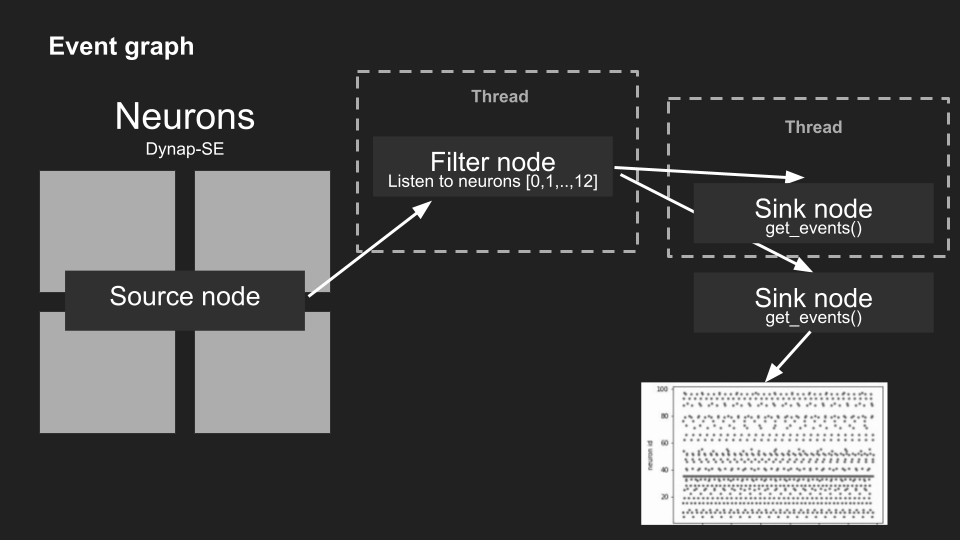

### 3.1 Specifying the neurons we are interested in

IDs go as triplets (chip_id, core_id, n_id)

In [21]:
global_ids = np.array([1,2,3,4,5,6])
neuron_ids = np.array([[1, 0, n_id] for n_id in global_ids])

### 3.2 Create a graph that would give us the events from the specified neurons

In [22]:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron_ids)


In [23]:
# Never forget to start the graph!

graph.start()

True

### 3.3 Let's get some events

The chip is always running, so once the `graph` has been started, the evens from the specified neurons are collected within the buffer. Once the `get_events()` function is called, the events are returned as a list, the buffer is emptied and continues to collect new coming events.

In [28]:
evts = sink_node.get_events()
len(evts)

14625

### 3.4 We can edit the filter node on the fly

If you change the list of neurons you record from in the filter node, the spikes from the new set of neurons will be recorded from the moment the function had been executed.

In [25]:
#filter_node.set_neurons(global_ids)
filter_node.set_neurons([[1, 0, n_id] for n_id in np.arange(0,100)])

In [27]:
filter_node.set_neurons(neuron_ids)

In [ ]:
# To stop the recording, stop the event graph
# graph.stop()

### Get some events and plot them instantly

Each event in the list has two properties: `timestamp` of the event in **microseconds** since the **last timestamp reset**, stamped by the chip's oboard FPGA; and the `neuron_id`.

701


Text(0, 0.5, 'neuron id')

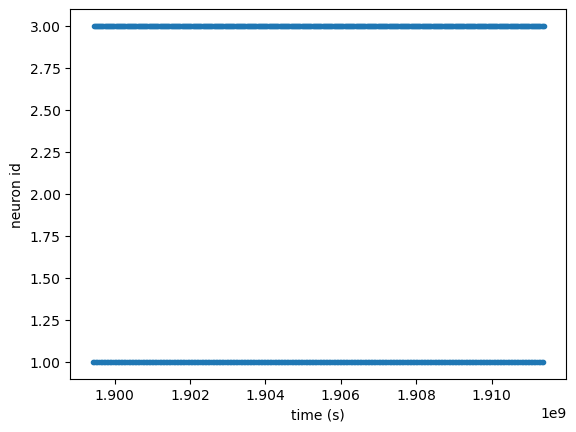

In [29]:
evts = sink_node.get_events()

print(len(evts))
evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in evts])

plt.plot(evts_n[:,0], evts_n[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("neuron id")

## 4. Providing input to the chip from the FPGA

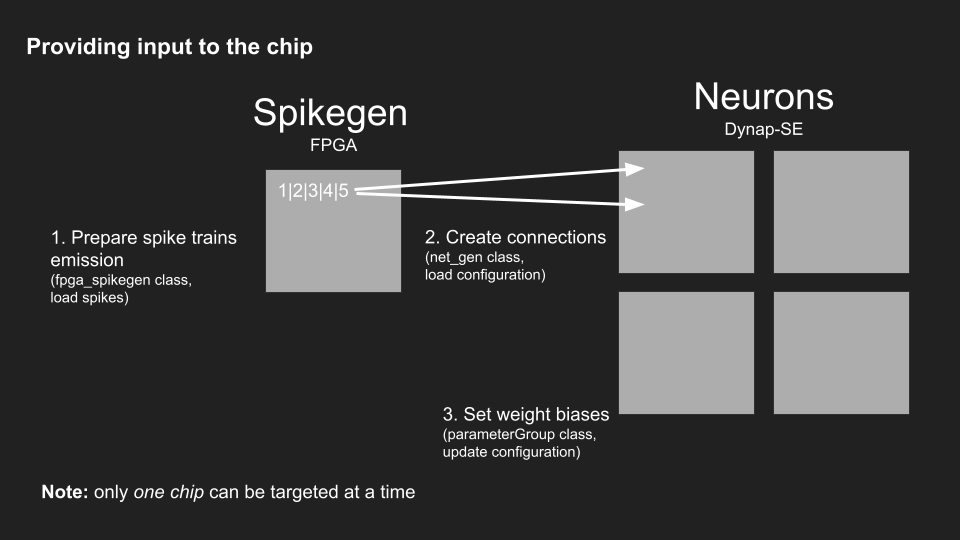

## 4.1 Preparing the spike trains

In [30]:
spikegen_ids = [1, 2]

FPGA limitations for the input spike train:

In [31]:
#Maximum ISI. Can be avoided with dummy spikes
MAX_ISI = 2**ISI_NUM_BITS-1
print(str(MAX_ISI*1e-06 * 10) + " s")

0.65535 s


In [32]:
#Maximum spike train length
MAX_LEN = 2**ADDR_NUM_BITS-1
print(MAX_LEN)

32767


In [33]:
#Spike train of spikegen 1
timestamps1 = np.linspace(0,1,100)
indices1 = np.ones(len(timestamps1))*spikegen_ids[0]

timestamps2 = np.linspace(0,1,200)
indices2 = np.ones(len(timestamps2))*spikegen_ids[1]

Text(0, 0.5, 'spikegen')

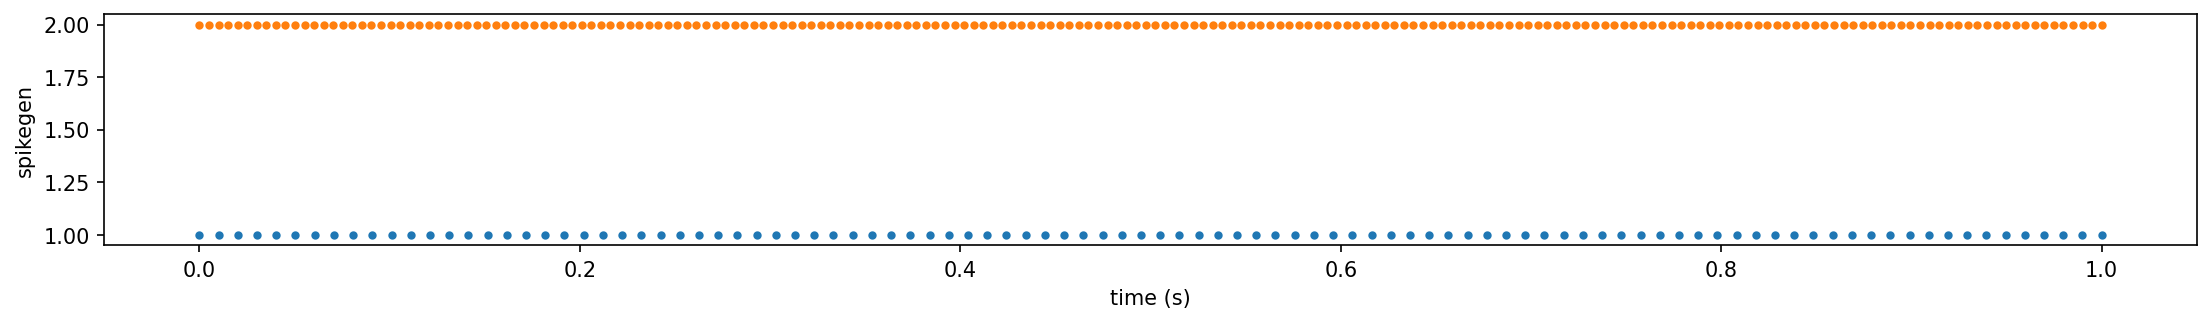

In [34]:
plt.figure(figsize=(18,2), dpi=150)
plt.plot(timestamps1, indices1, '.')
plt.plot(timestamps2, indices2, '.')
plt.xlabel("time (s)")
plt.ylabel("spikegen")

In [35]:
# Create a single SORTED spiketrain

spiketrain = np.concatenate((np.column_stack((timestamps1,indices1)), np.column_stack((timestamps2,indices2))))

In [36]:
#let's see the result

spiketrain

array([[0.        , 1.        ],
       [0.01010101, 1.        ],
       [0.02020202, 1.        ],
       [0.03030303, 1.        ],
       [0.04040404, 1.        ],
       [0.05050505, 1.        ],
       [0.06060606, 1.        ],
       [0.07070707, 1.        ],
       [0.08080808, 1.        ],
       [0.09090909, 1.        ],
       [0.1010101 , 1.        ],
       [0.11111111, 1.        ],
       [0.12121212, 1.        ],
       [0.13131313, 1.        ],
       [0.14141414, 1.        ],
       [0.15151515, 1.        ],
       [0.16161616, 1.        ],
       [0.17171717, 1.        ],
       [0.18181818, 1.        ],
       [0.19191919, 1.        ],
       [0.2020202 , 1.        ],
       [0.21212121, 1.        ],
       [0.22222222, 1.        ],
       [0.23232323, 1.        ],
       [0.24242424, 1.        ],
       [0.25252525, 1.        ],
       [0.26262626, 1.        ],
       [0.27272727, 1.        ],
       [0.28282828, 1.        ],
       [0.29292929, 1.        ],
       [0.

In [37]:
spiketrain = spiketrain[spiketrain[:,0].argsort()]

Text(0, 0.5, 'spikegen')

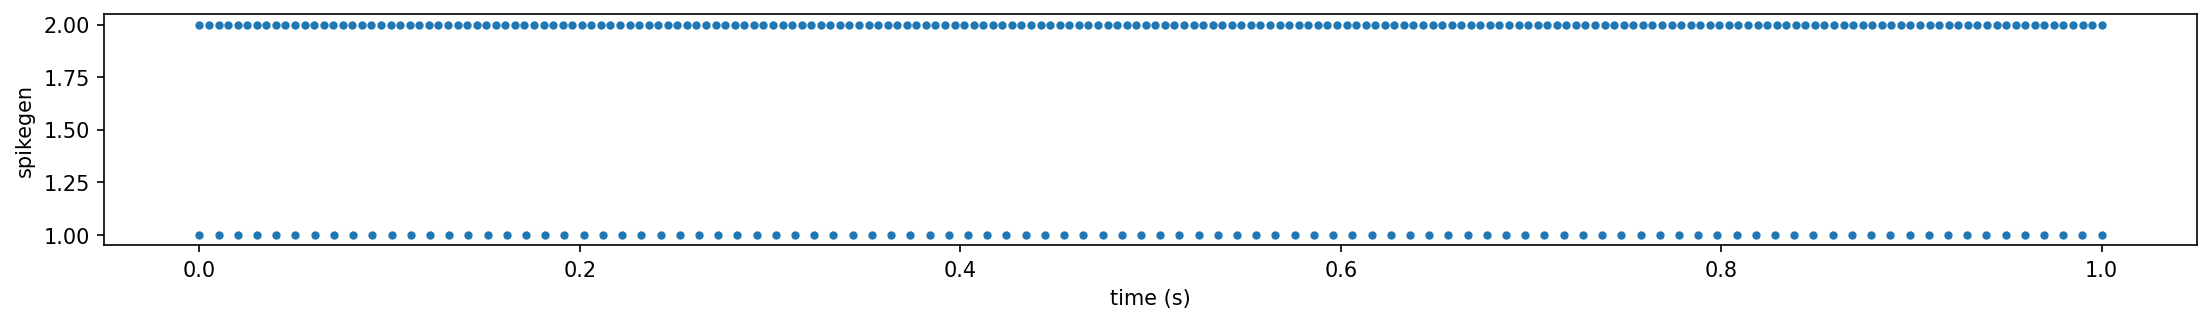

In [38]:
plt.figure(figsize=(18,2), dpi=150)
plt.plot(spiketrain[:,0], spiketrain[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("spikegen")

In [ ]:
fpga_spike_gen = model.get_fpga_spike_gen()
target_chip = 1

In [ ]:
ut.set_fpga_spike_gen(fpga_spike_gen, spike_times=spiketrain[:,0], indices=spiketrain[:,1].astype(int), target_chips=[target_chip]*len(spiketrain), isi_base=900, repeat_mode=True)

In [ ]:
fpga_spike_gen.start()

In [ ]:
fpga_spike_gen.stop()

### 4.2 Connecting the Spike Generator

In [ ]:
import netgen as n
from netgen import Neuron

In [ ]:
# if we look at the Neuron object, we see that is has a flag whether it is virtual or not. Virtual neurons are spike emitters on the FPGA
help(Neuron)

In [ ]:
# Let's create 2 virtual neurons

spikegen_neuron1 = Neuron(0,0,1,is_spike_gen=True)
spikegen_neuron2 = Neuron(0,0,2,is_spike_gen=True)

In [ ]:
# Let's target neurons 10 and 11

neurons = [Neuron(1,0,10), Neuron(1,0,11)]

In [ ]:
# initialize a networkgenerator

net_gen = n.NetworkGenerator()

In [ ]:
# All these connections are stored (or 'staged') locally and are not applied to the board right away

#net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegen_neuron2, neurons[0], dyn1.Dynapse1SynType.GABA_A)

In [ ]:
# print the network so you can double check (optional)
net_gen.print_network()

In [ ]:
net_gen.remove_connection(spikegen_neuron2, neurons[1], dyn1.Dynapse1SynType.AMPA)

In [ ]:
# make a dynapse1config using the network
new_config = net_gen.make_dynapse1_configuration()

In [ ]:
# apply the configuration
model.apply_configuration(new_config)

### misc leftovers

In [ ]:
# poissongen_id, range = [0, 1024)
poissongen_id = 1
rate = 200

# get poissongen from the model
poisson_gen = model.get_poisson_gen()
# set the target chip of the post neurons
post_chip = 1
poisson_gen.set_chip_id(post_chip)
poisson_gen.write_poisson_rate_hz(poissongen_id, rate)

# remember to start the poissongen
poisson_gen.start()

In [ ]:
poisson_gen.stop()

In [39]:
filter_node.set_neurons([(1,0,10),(1,0,11)])

In [40]:
graph.start()

False

Spikes collected: 63372


Text(0, 0.5, 'neuron id')

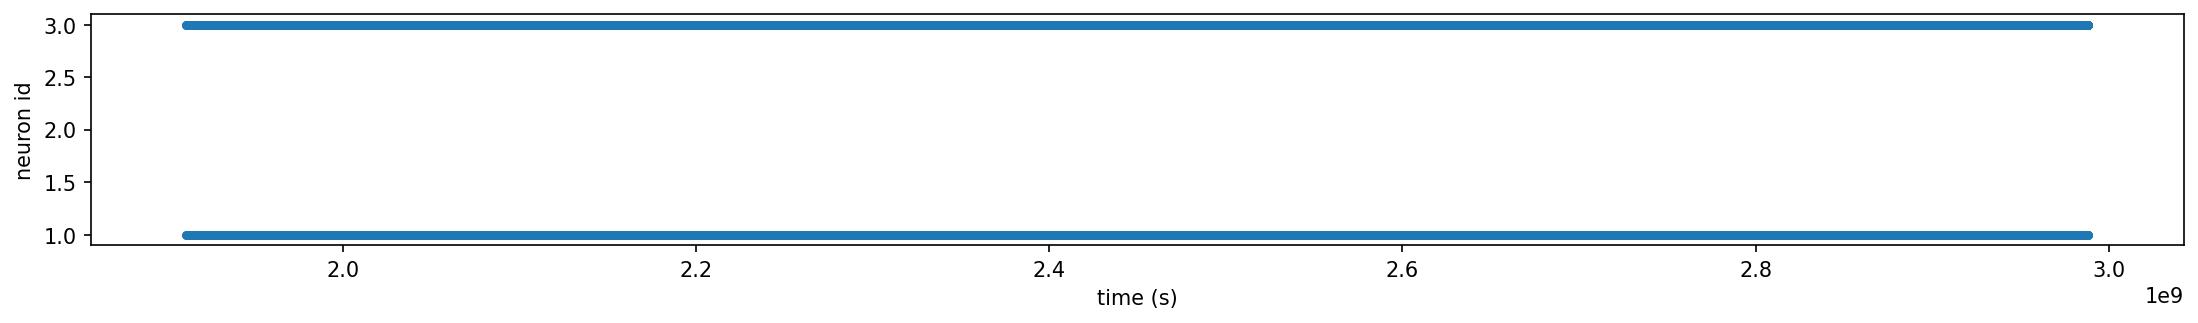

In [41]:
evts = sink_node.get_events()

print("Spikes collected:", len(evts))
evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in evts])

plt.figure(figsize=(18,2), dpi=150)
plt.plot(evts_n[:,0], evts_n[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("neuron id")

In [ ]:
graph.stop()

# What about time varying input?

In [ ]:
x = np.arange(0,4*np.pi,0.01)
y = np.sin(x)+1
y = y/y.max()
spikes = np.zeros(len(x))
spiketrain = []
for i in range(len(x)):
    if np.random.rand() < y[i]:
        spikes[i]=1

        
fig = plt.figure()
plt.plot(x,y)
plt.plot(x, spikes, '.')

len(spikes)

In [ ]:
timestamps = 4*x/(4*np.pi)
indices = spikes+1

plt.figure(figsize=(18,2), dpi=150)
plt.plot(timestamps, indices, '.')
plt.xlabel("time (s)")
plt.ylabel("spikegen")

In [ ]:
ut.set_fpga_spike_gen(fpga_spike_gen, spike_times=timestamps, indices=indices.astype(int), target_chips=[target_chip]*len(timestamps), isi_base=900, repeat_mode=True)

In [ ]:
fpga_spike_gen.start()

In [ ]:
fpga_spike_gen.stop()

In [ ]:
net_gen = n.NetworkGenerator()

In [ ]:
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.GABA_A)
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.GABA_B)

In [ ]:
net_gen.print_network()

In [ ]:
import STDP_plotter

neuron_ids = [10,11]

STDP_plotter.run_plotting_thread(neuron_ids, sink_node, refresh_rate = 500)

In [ ]:
global_ids = np.array([10, 11])

In [ ]:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, global_ids)

In [ ]:
graph.start()